# Text Sentiment Analysis Prediction Using Disneyland Review

# David Berberena

# 11/17/2024

### Library and Dataset Importation

In [1]:
# I will import the necessary libraries needed for data mining, exploratory data analysis, and data preparation here.

import numpy as np
import pandas as pd
import requests
import calendar
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

In [2]:
# To load in the dataset, due to its large size I needed to access GitHub's API to access and read it into the environment. 
# To make sure I have captured the entirety of the dataset, I will have the if-else statement print the dataset's summary 
# information, which will show me the first and last five columns of data and the DataFrame's shape. 

owner = 'SosukeAizen5'  
repo = 'Portfolio'
path = 'DSC%20680%20Applied%20Data%20Science/DisneylandReviews.csv'

url = f'https://api.github.com/repos/{owner}/{repo}/contents/{path}'
headers = {'Accept': 'application/vnd.github.v3.raw'}

response = requests.get(url, headers = headers, stream = True)

if response.status_code == 200:
    disneylands = pd.read_csv(response.raw, low_memory = False)
    print(disneylands.info)
else:
    print(f'Error: {response.status_code} - Unable to retrieve file')

<bound method DataFrame.info of        Review_ID  Rating Year_Month     Reviewer_Location  \
0      670772142       4     2019-4             Australia   
1      670682799       4     2019-5           Philippines   
2      670623270       4     2019-4  United Arab Emirates   
3      670607911       4     2019-4             Australia   
4      670607296       4     2019-4        United Kingdom   
...          ...     ...        ...                   ...   
42651    1765031       5    missing        United Kingdom   
42652    1659553       5    missing                Canada   
42653    1645894       5    missing          South Africa   
42654    1618637       4    missing         United States   
42655    1536786       4    missing        United Kingdom   

                                             Review_Text               Branch  
0      If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1      Its been a while since d last time we visit HK...  Disneyland_HongKo

### Data Preparation

In [3]:
# As we have seen above, there are some missing values within the dataset, so I will scan for anymore not yet seen or 
# denoted as NaN using the .isna().sum() function.

disneylands.isna().sum()

Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64

In [4]:
# To drop the columns that contain the "missing" values, I will first replace the "missing" values with NaN, which is 
# recognized by Python.

disneylands.replace('missing', np.nan, inplace = True)

# Now I can drop these columns using dropna().

disneylands.dropna(inplace = True)

# To verify that this has been done properly, I will output the tail of the dataset along with its shape.

print(disneylands.shape)
print(disneylands.tail())

(40043, 6)
       Review_ID  Rating Year_Month Reviewer_Location  \
42113   92198076       4     2011-1    United Kingdom   
42114   92061774       4     2011-1           Germany   
42115   91995748       1    2010-12    United Kingdom   
42116   91984642       2    2010-12    United Kingdom   
42117   91827418       5     2010-9    United Kingdom   

                                             Review_Text            Branch  
42113  Although our pick up was prompt the taxi drive...  Disneyland_Paris  
42114  Just returned from a 4 days family trip to Dis...  Disneyland_Paris  
42115  We spent the 20 Dec 2010 in the Disney park an...  Disneyland_Paris  
42116  Well I was really looking forward to this trip...  Disneyland_Paris  
42117  If staying at a Disney hotel make good use of ...  Disneyland_Paris  


In [5]:
# We can see that over 2000 observations have been removed. Next, I will remove the Review_ID feature as it is irrelevant to
# the purpose of the study. This will be done using the drop() function.

disneylands.drop(columns = ['Review_ID'], inplace = True)

# I will use the head() function here to verify the change has been made correctly.

disneylands.head()

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [6]:
# I will now check the data types of each column's observations within the dataset. I can do this using .dtypes.

disneylands.dtypes

Rating                int64
Year_Month           object
Reviewer_Location    object
Review_Text          object
Branch               object
dtype: object

In [7]:
# I'd like to break up the Year_Month variable into separate features of year and month, so I will split this column into 
# two distinct variables using str.split(), set each variable's data type as integer values, and have the month variable 
# show the month name instead of a number representing the month the review was made.

split_features = disneylands['Year_Month'].str.split('-', n = 1, expand = True) 
 
disneylands['Year'] = split_features[0].astype(int)
disneylands['Month'] = split_features[1].astype(int)

disneylands['Month'] = disneylands['Month'].apply(lambda x: calendar.month_name[x])

# Now that the new columns have been made, I will drop the original combined column.
   
disneylands.drop(columns = ['Year_Month'], inplace = True) 

# I will use the head() function here to verify the change has been made correctly.

disneylands.head()

,Rating,Reviewer_Location,Review_Text,Branch,Year,Month
0,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,April
1,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,May
2,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,April
3,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,April
4,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,April


In [8]:
# For better readability and aesthetics, I will rename the Branch column and replace the values within that column using the
# rename() and replace() functions.

disneylands.rename(columns = {'Branch': 'Disneyland_Branch'}, inplace = True)

disneylands['Disneyland_Branch'].replace({'Disneyland_HongKong': 'Hong Kong', 'Disneyland_California': 'California', 
                                          'Disneyland_Paris': 'Paris'}, inplace = True)

# I will use the head() function here to verify the change has been made correctly.

disneylands.head()

,Rating,Reviewer_Location,Review_Text,Disneyland_Branch,Year,Month
0,4,Australia,If you've ever been to Disneyland anywhere you...,Hong Kong,2019,April
1,4,Philippines,Its been a while since d last time we visit HK...,Hong Kong,2019,May
2,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Hong Kong,2019,April
3,4,Australia,HK Disneyland is a great compact park. Unfortu...,Hong Kong,2019,April
4,4,United Kingdom,"the location is not in the city, took around 1...",Hong Kong,2019,April


In [9]:
# To attach sentiment to the reviews present in the Review_Text column, I will duplicate the Rating feature and rename it 
# while replacing the number values with sentiments (a rating of 1 will be considered a highly negative review, 2 will be a 
# negative review, 3 will be neutral, 4 will be positive, and a rating of 5 will be a highly positive review).

disneylands['Sentiment'] = disneylands['Rating']

disneylands['Sentiment'].replace({1: 'Highly Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 
                                  5: 'Highly Positive'}, inplace = True)

# I will use the head() function here to verify the change has been made correctly.

disneylands.head()

,Rating,Reviewer_Location,Review_Text,Disneyland_Branch,Year,Month,Sentiment
0,4,Australia,If you've ever been to Disneyland anywhere you...,Hong Kong,2019,April,Positive
1,4,Philippines,Its been a while since d last time we visit HK...,Hong Kong,2019,May,Positive
2,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Hong Kong,2019,April,Positive
3,4,Australia,HK Disneyland is a great compact park. Unfortu...,Hong Kong,2019,April,Positive
4,4,United Kingdom,"the location is not in the city, took around 1...",Hong Kong,2019,April,Positive


In [10]:
# So the dataset can be read easier, I will reorder the columns in preparation for the review text to be preprocessed.

column_order = ['Year', 'Month', 'Reviewer_Location', 'Disneyland_Branch', 'Review_Text', 'Rating', 'Sentiment']

disneylands = disneylands[column_order]

# I will use the head() function here to verify the change has been made correctly.

disneylands.head()

,Year,Month,Reviewer_Location,Disneyland_Branch,Review_Text,Rating,Sentiment
0,2019,April,Australia,Hong Kong,If you've ever been to Disneyland anywhere you...,4,Positive
1,2019,May,Philippines,Hong Kong,Its been a while since d last time we visit HK...,4,Positive
2,2019,April,United Arab Emirates,Hong Kong,Thanks God it wasn t too hot or too humid wh...,4,Positive
3,2019,April,Australia,Hong Kong,HK Disneyland is a great compact park. Unfortu...,4,Positive
4,2019,April,United Kingdom,Hong Kong,"the location is not in the city, took around 1...",4,Positive


In [11]:
# I wish to see the number of reviews within each sentiment classification. I will print the totals here.

review_counts = disneylands['Sentiment'].value_counts()

print('The totals of each review classification for the three Disneyland branches within the data are shown below.\n')
print('Highly Positive reviews:', review_counts['Highly Positive'])
print('Positive reviews:', review_counts['Positive'])
print('Neutral reviews:', review_counts['Neutral'])
print('Negative reviews:', review_counts['Negative'])
print('Highly Negative reviews:', review_counts['Highly Negative'])

The totals of each review classification for the three Disneyland branches within the data are shown below.

Highly Positive reviews: 21908
Positive reviews: 10086
Neutral reviews: 4782
Negative reviews: 1929
Highly Negative reviews: 1338


In [12]:
# The last thing I wish to see is the number of reviews present in the dataset for each Disneyland branch to get an 
# idea of how evenly distributed the reviews are. Seaborn's barplot() can help with this after utilizing the value_counts()
# and reset_index() functions.

counts = disneylands['Disneyland_Branch'].value_counts().reset_index()
counts.columns = ['Disneyland Branch', 'Number of Reviews']

print(counts)

  Disneyland Branch  Number of Reviews
0        California              18202
1             Paris              12694
2         Hong Kong               9147


In [13]:
# Here we can see that Disneyland California has many more reviews within the dataset than both Paris and Hong Kong. This 
# uneven distribution of reviews makes it difficult to avoid bias towards the Disneyland California reviews. After the 
# initial exploratory data analysis phase, I will split the dataset into three separate datasets (one for each Disneyland
# branch) to solve this issue. I believe the splitting of the dataset by branch location will also capture cultural 
# differences in what is considered important for guests of each Disneyland branch. For now, I wish to see the underlying 
# trends in the entire dataset via EDA.

### Initial Explatory Data Analysis

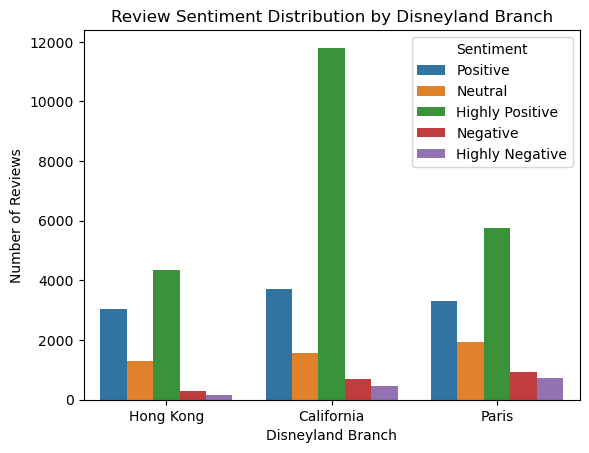

In [14]:
# To begin the EDA phase, there are several visualizations that can be output to see some of the trends
# hidden within the data. Continuing on with looking at the distribution of reviews, the next thing I wish to see from the 
# data is the review sentiment distribution for Disneyland California. I can visualize this information by using Seaborn's 
# countplot() function.

sns.countplot(data = disneylands, x = 'Disneyland_Branch', hue = 'Sentiment')
plt.title('Review Sentiment Distribution by Disneyland Branch')
plt.xlabel('Disneyland Branch')
plt.ylabel('Number of Reviews')
plt.legend(title = 'Sentiment')
plt.show()

In [15]:
# It is very reassuring to see that there are many more highly positive and positive reviews for each Disneyland branch than
# the other review sentiments. It is interesting to note that there are more highly negative, negative, and neutral reviews
# for Disneyland Paris than there are for California when California has almost fifty percent more total reviews than Paris.
# This showcases a higher proportion of dissatisfaction with Disneyland Paris than the other two branches in the data.

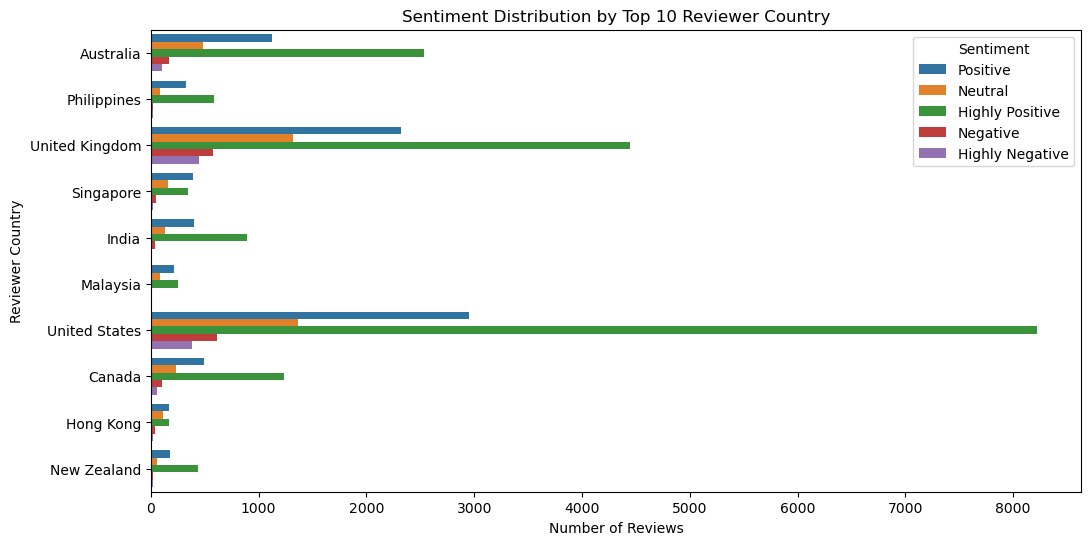

In [16]:
# The next underlying trend I wish to visualize is the sentiment of the top ten countries where reviewers are from. Those
# countries whose residents left the most reviews within the dataset have a large impact on how the rest of the world views
# Disneyland branches, so seeing the countries and their residents' sentiment towards the three Disneyland branches here 
# allows us to understand which countries have the most involvement in reviews.

top_10_locations = disneylands['Reviewer_Location'].value_counts().head(10).index
location_counts = disneylands[disneylands['Reviewer_Location'].isin(top_10_locations)]

plt.figure(figsize = (12,6))
sns.countplot(data = location_counts, y = 'Reviewer_Location', hue = 'Sentiment')
plt.title('Sentiment Distribution by Top 10 Reviewer Country')
plt.xlabel('Number of Reviews')
plt.ylabel('Reviewer Country')
plt.legend(title = 'Sentiment')
plt.show()

In [17]:
# With this visualization, we can see that the United States dominates the reviews, followed by the United Kingdom. There 
# are many reasons why this could be, from the fact that there are more total reviews for Disneyland California to the ease
# of access and knowledge of TripAdvisor. It is important to notate this disparity as we move along in our research.

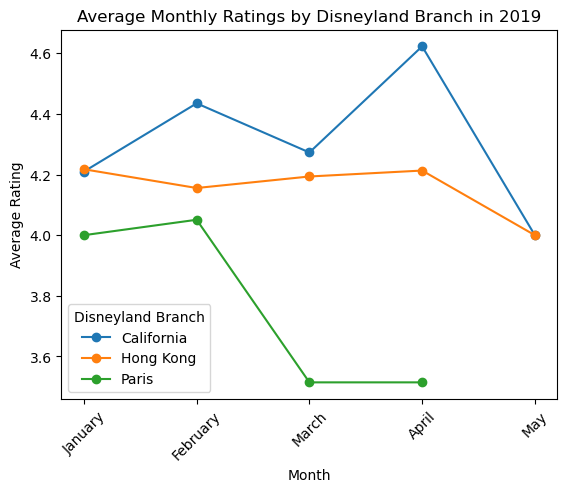

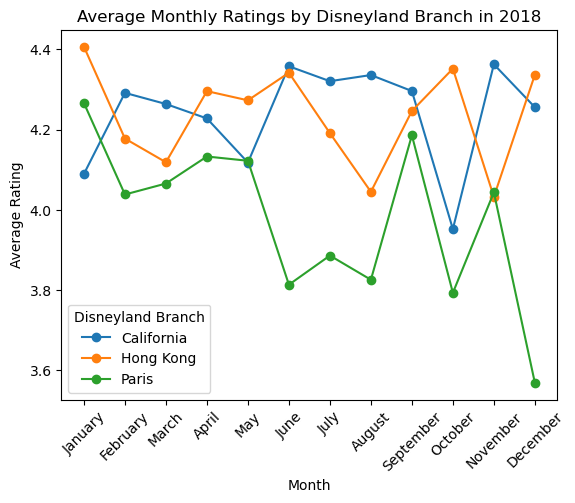

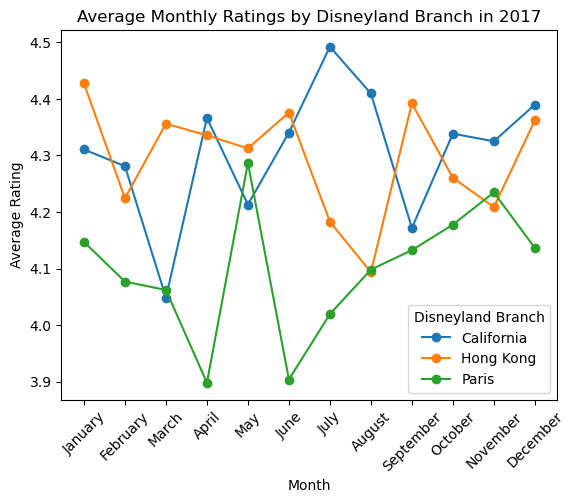

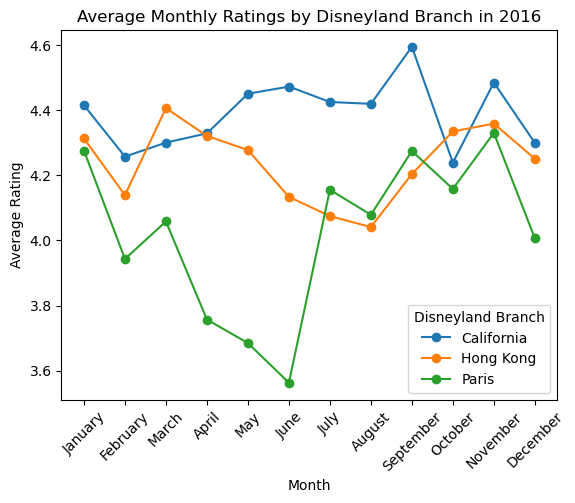

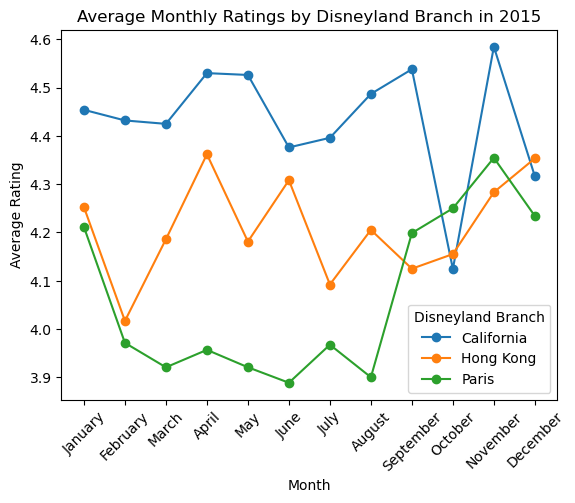

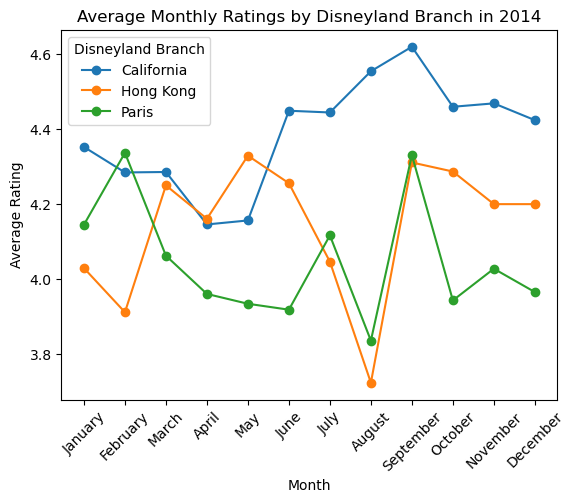

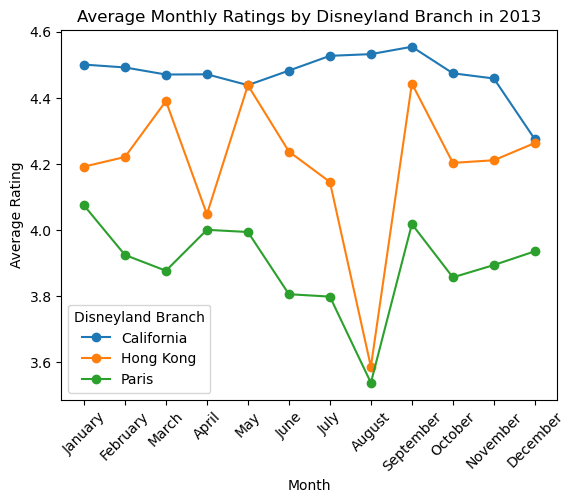

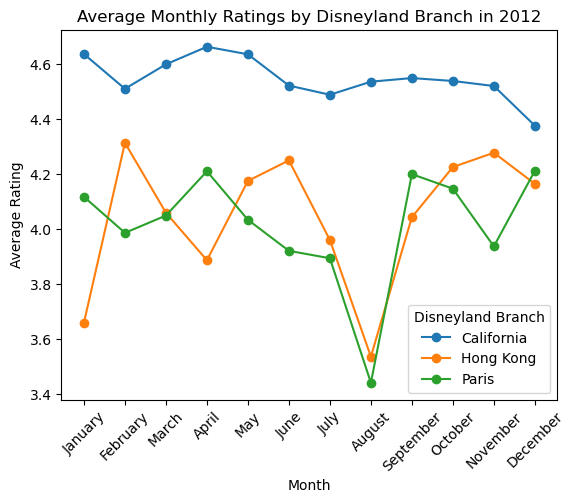

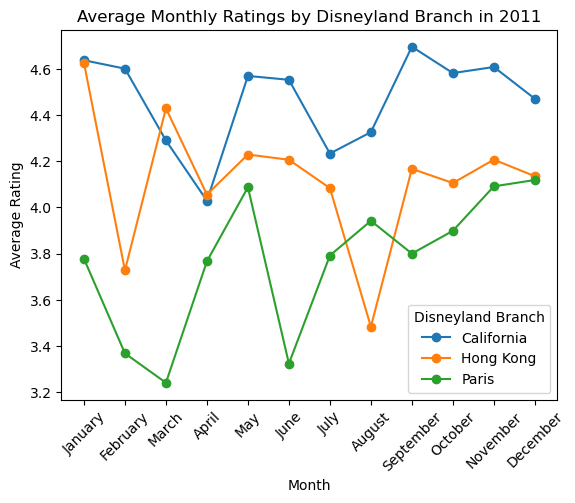

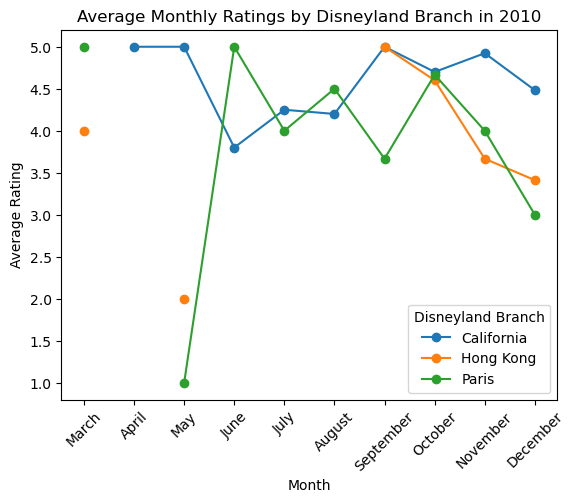

In [18]:
# With the data we currently possess, we can also see the average monthly reviewer sentiment by Disneyland branch for each 
# year present in the dataset. To do this, I will order the 'Month' variable and convert it into a categorical feature, 
# extract each unique year within the data, group each year's data by month and average reviewer sentiment (the 'Rating' 
# variable will be used to represent numerical reviewer sentiment), and plot the average monthly ratings for each year using
# a nested for loop.

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November',
               'December']
disneylands['Month'] = pd.Categorical(disneylands['Month'], categories = month_order, ordered = True)

unique_years = disneylands['Year'].unique()

for year in unique_years:
    year_data = disneylands[disneylands['Year'] == year]
    
    monthly_ratings = year_data.groupby(['Month', 'Disneyland_Branch'])['Rating'].mean().unstack()

    for branch in monthly_ratings.columns:
        plt.plot(monthly_ratings.index, monthly_ratings[branch], marker = 'o', label = branch)

    plt.title(f'Average Monthly Ratings by Disneyland Branch in {year}')
    plt.xlabel('Month')
    plt.ylabel('Average Rating')
    plt.xticks(rotation = 45)
    plt.legend(title = 'Disneyland Branch')
    plt.show()



In [19]:
# After seeing some of the charts, there are months within certain years that no reviews were provided, and there are quite
# a few years where the average ratings were volatile in their fluctuations. While this pattern identification holds little
# value to the study goals, it is interesting to note how numerical review sentiment showcases such volatility while textual
# review sentiment has little opportunity and/or ability to highlight that same volatility. 

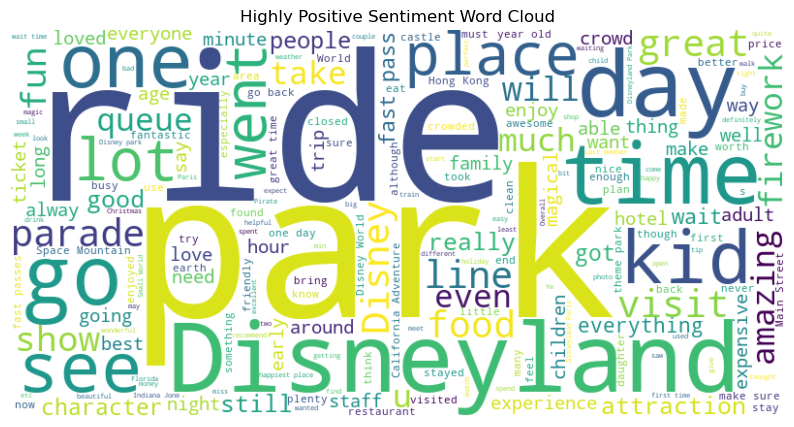

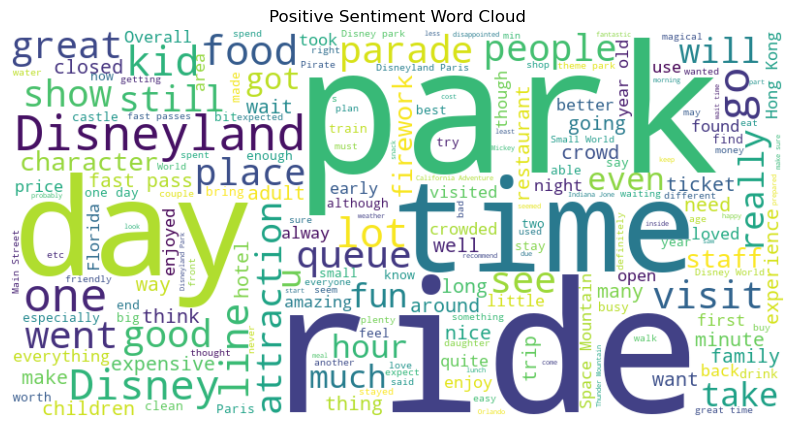

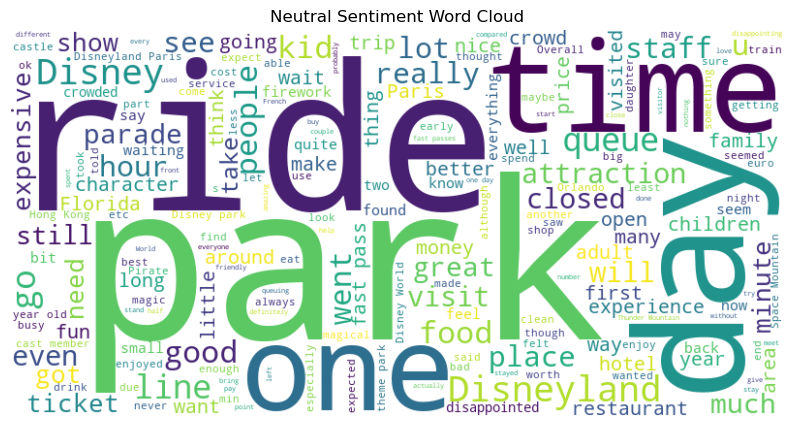

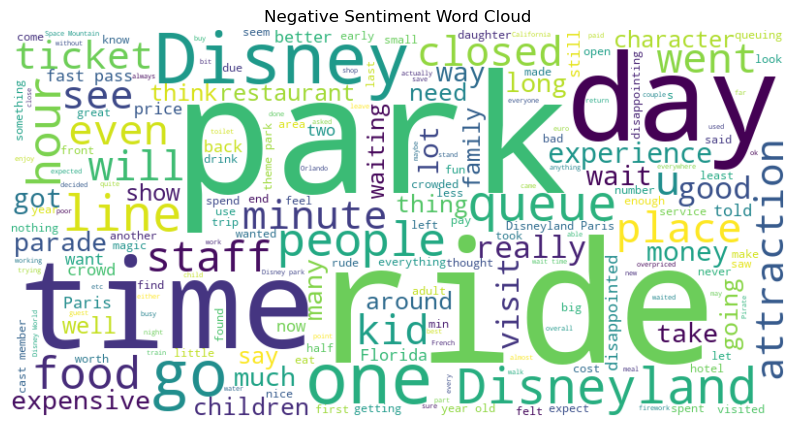

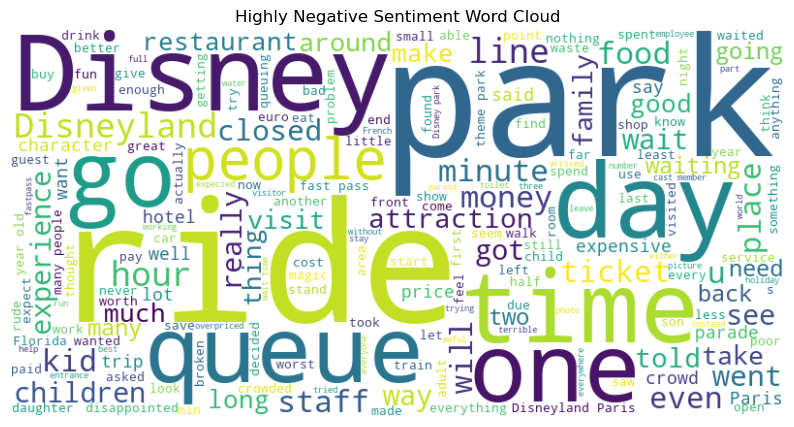

In [20]:
# My final means of initially exploring the data is to craft a word cloud for each sentiment classifcation illustrating the 
# most commonly used words in the reviews under each sentiment classification. I have created a dictionary containing all 
# the words featured in each sentiment classification and a for loop which creates a word cloud for each sentiment class.

sentiments = {'Highly Positive': " ".join(disneylands[disneylands['Sentiment'] == 'Highly Positive']['Review_Text']), 
              'Positive': " ".join(disneylands[disneylands['Sentiment'] == 'Positive']['Review_Text']), 
              'Neutral': " ".join(disneylands[disneylands['Sentiment'] == 'Neutral']['Review_Text']), 
              'Negative': " ".join(disneylands[disneylands['Sentiment'] == 'Negative']['Review_Text']), 
              'Highly Negative': " ".join(disneylands[disneylands['Sentiment'] == 'Highly Negative']['Review_Text'])}

# Create word clouds for each sentiment
for sentiment, reviews in sentiments.items():
    plt.figure(figsize = (10, 6))
    disneyland_sentiment_wordclouds = WordCloud(width = 800, height = 400, background_color = 'white').generate(reviews)
    plt.imshow(disneyland_sentiment_wordclouds, interpolation = 'bilinear')
    plt.title(f'{sentiment} Sentiment Word Cloud')
    plt.axis('off')
    plt.show()

In [21]:
# Upon viewing the different word clouds, we can see that as we descend from highly positive to highly negative reviews, we
# can see that words related to waiting in line for a long time are more prevalent and the presence of characters and fun 
# has almost completely disappeared. These words will prove significant to the various machine learning models being 
# employed to predict review sentiment. 

### Textual Preprocessing

In [22]:
# Now that the dataset is prepared for textual preprocessing, we can see if the dataset's ability to distinguish review 
# sentiment is as accurate as an automated text sentiment analyzer. I will be using the TextBlob() function to compute 
# the sentiment polarity of each review and classify the reviews by their polarity scores as either highly positive, 
# positive, neutral, negative, or highly negative. The polarity score threshold has been split according to the ratings 
# provided in the Rating feature.

def get_sentiment_class(polarity):
    if polarity > 0.6:
        return 'Highly Positive'
    elif 0.2 < polarity <= 0.6:
        return 'Positive'
    elif -0.2 <= polarity <= 0.2:
        return 'Neutral'
    elif -0.6 <= polarity < -0.2:
        return 'Negative'
    else:
        return 'Highly Negative'

    
# Two new features will be added to the dataset, one being Polarity, which will hold the sentiment polarity scores of the 
# reviews calculated by TextBlob(), and the other being New_Sentiment, which is to house the review classes.

disneylands['Polarity'] = disneylands['Review_Text'].apply(lambda text: TextBlob(text).sentiment.polarity)
disneylands['New_Sentiment'] = disneylands['Polarity'].apply(get_sentiment_class)

# I will use the head() function here to verify the change has been made correctly.

disneylands.head()

,Year,Month,Reviewer_Location,Disneyland_Branch,Review_Text,Rating,Sentiment,Polarity,New_Sentiment
0,2019,April,Australia,Hong Kong,If you've ever been to Disneyland anywhere you...,4,Positive,0.243981,Positive
1,2019,May,Philippines,Hong Kong,Its been a while since d last time we visit HK...,4,Positive,0.236131,Positive
2,2019,April,United Arab Emirates,Hong Kong,Thanks God it wasn t too hot or too humid wh...,4,Positive,0.160498,Neutral
3,2019,April,Australia,Hong Kong,HK Disneyland is a great compact park. Unfortu...,4,Positive,0.189286,Neutral
4,2019,April,United Kingdom,Hong Kong,"the location is not in the city, took around 1...",4,Positive,0.266667,Positive


In [23]:
# Now that we have seen the overwhelming bias towards Disneyland California with the total number of reviews against the 
# other two branches, I have decided to subset the entire dataset to create three datasets (one for each branch). I will
# continue this study by analyzing each branch separately from the others for branch-specific results. 

dl_cali = disneylands[disneylands['Disneyland_Branch'] == 'California']
dl_paris = disneylands[disneylands['Disneyland_Branch'] == 'Paris']
dl_hk = disneylands[disneylands['Disneyland_Branch'] == 'Hong Kong']

# To make sure the datasets have been created correctly, I will output each dataset's shape.

print(dl_cali.shape)
print(dl_paris.shape)
print(dl_hk.shape)

(18202, 9)
(12694, 9)
(9147, 9)


In [24]:
# As I did earlier, I will print the number of reviews within each review sentiment classification, but this will be done 
# for each Disneyland branch. To output these results, I have made a for loop that counts the number of reviews in each 
# review sentiment class and prints the class totals for each Disneyland branch dataset.

disneyland_branches = [dl_cali, dl_paris, dl_hk]
branch_names = ['California', 'Paris', 'Hong Kong']

print('The new totals of each review class for the Disneyland branches within each dataset are shown below.')

for branch, data in zip(branch_names, disneyland_branches):
    new_review_counts = data['New_Sentiment'].value_counts()
    
    print(f'\nDisneyland {branch} Review Counts')
    print('Highly Positive reviews:', new_review_counts.get('Highly Positive', 0))
    print('Positive reviews:', new_review_counts.get('Positive', 0))
    print('Neutral reviews:', new_review_counts.get('Neutral', 0))
    print('Negative reviews:', new_review_counts.get('Negative', 0))
    print('Highly Negative reviews:', new_review_counts.get('Highly Negative', 0))

The new totals of each review class for the Disneyland branches within each dataset are shown below.

Disneyland California Review Counts
Highly Positive reviews: 607
Positive reviews: 9782
Neutral reviews: 7634
Negative reviews: 166
Highly Negative reviews: 13

Disneyland Paris Review Counts
Highly Positive reviews: 247
Positive reviews: 5321
Neutral reviews: 6970
Negative reviews: 148
Highly Negative reviews: 8

Disneyland Hong Kong Review Counts
Highly Positive reviews: 182
Positive reviews: 4713
Neutral reviews: 4145
Negative reviews: 106
Highly Negative reviews: 1


In [25]:
# With the new review sentiment values counted for each Disneyland branch dataset, I will create a for loop that outputs
# the accuracy metric and the classification report, which includes the precision, recall, and F-1 scores for each TextBlob
# sentiment analysis.

for branch, data in zip(branch_names, disneyland_branches):
    blob_accuracy = accuracy_score(data['Sentiment'], data['New_Sentiment'])
    
    blob_report = classification_report(data['Sentiment'], data['New_Sentiment'], 
                                        target_names=['Highly Positive', 'Positive', 
                                                      'Neutral', 'Negative', 
                                                      'Highly Negative'])
    
    print(f'\nDisneyland {branch} TextBlob Performance Metrics')
    print(f'\nAccuracy: {blob_accuracy}\n')
    print(f'{blob_report}\n')


Disneyland California TextBlob Performance Metrics

Accuracy: 0.18926491594330294

                 precision    recall  f1-score   support

Highly Positive       0.08      0.00      0.00       450
       Positive       0.88      0.05      0.09     11802
        Neutral       0.14      0.04      0.06       685
       Negative       0.15      0.74      0.25      1552
Highly Negative       0.18      0.47      0.26      3713

       accuracy                           0.19     18202
      macro avg       0.29      0.26      0.13     18202
   weighted avg       0.63      0.19      0.13     18202



Disneyland Paris TextBlob Performance Metrics

Accuracy: 0.2453127461792973

                 precision    recall  f1-score   support

Highly Positive       0.25      0.00      0.01       736
       Positive       0.82      0.04      0.07      5768
        Neutral       0.22      0.03      0.06       937
       Negative       0.22      0.80      0.35      1933
Highly Negative       0.25      0.4

In [26]:
# As seen by the results just printed, the accuracy and other performance metrics are very low for each Disneyland branch, 
# meaning that the review sentiments generated by TextBlob matched poorly with the actual review sentiments as defined by 
# the numerical ratings. To further illustrate the poor performance of the TextBlob analysis, I will output a confusion 
# matrix for each Disneyland branch. For better readability, I will convert the confusion matrix into a DataFrame with the 
# review sentiment classification labels.

labels = ['Highly Positive', 'Positive', 'Neutral', 'Negative', 'Highly Negative']

for branch, data in zip(branch_names, disneyland_branches):
    confusion_matrices = confusion_matrix(data['Sentiment'], data['New_Sentiment'], labels = labels)

    blob_confusion = pd.DataFrame(confusion_matrices, index = labels, columns = labels)
    
    print(f'\nDisneyland {branch} Confusion Matrix')
    print(blob_confusion)


Disneyland California Confusion Matrix
                 Highly Positive  Positive  Neutral  Negative  Highly Negative
Highly Positive              537      7578     3631        48                8
Positive                      61      1738     1886        26                2
Neutral                        6       360     1145        39                2
Negative                       2        81      578        24                0
Highly Negative                1        25      394        29                1

Disneyland Paris Confusion Matrix
                 Highly Positive  Positive  Neutral  Negative  Highly Negative
Highly Positive              203      3547     2003        15                0
Positive                      38      1327     1933        21                1
Neutral                        6       350     1550        24                3
Negative                       0        69      834        32                2
Highly Negative                0        28      650     

With the TextBlob model providing us with a baseline insight as to how the review sentiments have been classified, we can see that there is much room for improvement. Utilizing more complex predictive models may provide much more accurate results, yet textual preprocessing must be done to employ those models. It is important to note that without any preprocessing, the datasets stand as follows:

Disneyland California: 18.92% accuracy
Disneyland Paris: 24.53% accuracy
Disneyland Hong Kong: 28.29% accuracy

In [27]:
# I will start the textual preprocessing by displaying each Disneyland branch dataset's first few values to visualize the 
# Review_Text variables.

print(dl_cali.head())
print(dl_paris.head())
print(dl_hk.head())

      Year  Month Reviewer_Location Disneyland_Branch  \
9620  2019  April     United States        California   
9621  2019  April     United States        California   
9622  2019    May         Australia        California   
9623  2019  April     United States        California   
9624  2019  April            Canada        California   

                                            Review_Text  Rating  \
9620  This place has always been and forever will be...       5   
9621  A great day of simple fun and thrills. Bring c...       5   
9622  All and all a great day was had. The crowds ar...       4   
9623  Having been to the Florida location numerous t...       5   
9624  Had the 4 day pass, spent 3 at DL and one at C...       5   

            Sentiment  Polarity New_Sentiment  
9620  Highly Positive  0.311429      Positive  
9621  Highly Positive  0.397222      Positive  
9622         Positive  0.153571       Neutral  
9623  Highly Positive  0.225694      Positive  
9624  Highly P

In [28]:
# The first transformation will be to set each review in all three datasets to lowercase. I will use str.lower() to do this.
# Afterward, I will be applying a lambda function that checks each review (converted into a string value since it has not 
# been done yet) for alphanumeric characters (with the isalnum() function) and space characters (using the isspace() 
# function) and keeps them (removing the remaining punctuation and special characters by default). The lambda function 
# finally joins each review back together at the whitespaces left by the exclusion of the unwanted characters.

dl_cali['Review_Text'] = dl_cali['Review_Text'].str.lower()
dl_paris['Review_Text'] = dl_paris['Review_Text'].str.lower()
dl_hk['Review_Text'] = dl_hk['Review_Text'].str.lower()

dl_cali['Review_Text'] = dl_cali['Review_Text'].apply(
    lambda review: ''.join(str(character) for character in review if character.isalnum() or character.isspace()))
dl_paris['Review_Text'] = dl_paris['Review_Text'].apply(
    lambda review: ''.join(str(character) for character in review if character.isalnum() or character.isspace()))
dl_hk['Review_Text'] = dl_hk['Review_Text'].apply(
    lambda review: ''.join(str(character) for character in review if character.isalnum() or character.isspace()))

# I will use the head() function here to verify the change has been made correctly.

print(dl_cali.head())
print(dl_paris.head())
print(dl_hk.head())

      Year  Month Reviewer_Location Disneyland_Branch  \
9620  2019  April     United States        California   
9621  2019  April     United States        California   
9622  2019    May         Australia        California   
9623  2019  April     United States        California   
9624  2019  April            Canada        California   

                                            Review_Text  Rating  \
9620  this place has always been and forever will be...       5   
9621  a great day of simple fun and thrills bring ca...       5   
9622  all and all a great day was had the crowds are...       4   
9623  having been to the florida location numerous t...       5   
9624  had the 4 day pass spent 3 at dl and one at ca...       5   

            Sentiment  Polarity New_Sentiment  
9620  Highly Positive  0.311429      Positive  
9621  Highly Positive  0.397222      Positive  
9622         Positive  0.153571       Neutral  
9623  Highly Positive  0.225694      Positive  
9624  Highly P

In [29]:
# Next, I will remove the stopwords within the reviews. To have access to the stopwords in the English language, I used the 
# words() function in stopwords and specified English as the language whose stopwords I wish to use and stored those words 
# into a set variable to call on in my function to remove these stopwords from the Review_Text variable. 

stop_words = set(stopwords.words('english'))

# The delete_stopwords() function I made is similar to the lambda function that removed the special characters and 
# punctuation, except that I encased the code in a recallable function. The function works to split the review into 
# individual words, analyze them to identify the stopwords and keep the words that are not stopwords, then join the words 
# to keep with the join() function where the stopwords were deleted. The joined review is returned at the end. 

def delete_stopwords(review):
    kept_words = [word for word in review.split() if word not in stop_words]
    return ' '.join(kept_words)

# The above function is applied to each review in each Disneyland branch dataset with the apply() function.

dl_cali['Review_Text'] = dl_cali['Review_Text'].apply(delete_stopwords)
dl_paris['Review_Text'] = dl_paris['Review_Text'].apply(delete_stopwords)
dl_hk['Review_Text'] = dl_hk['Review_Text'].apply(delete_stopwords)

# I will use the head() function here to verify the change has been made correctly.

print(dl_cali.head())
print(dl_paris.head())
print(dl_hk.head())

      Year  Month Reviewer_Location Disneyland_Branch  \
9620  2019  April     United States        California   
9621  2019  April     United States        California   
9622  2019    May         Australia        California   
9623  2019  April     United States        California   
9624  2019  April            Canada        California   

                                            Review_Text  Rating  \
9620  place always forever special feeling get enter...       5   
9621  great day simple fun thrills bring cash nothin...       5   
9622  great day crowds huge ride times sometimes 50 ...       4   
9623  florida location numerous times years didnt kn...       5   
9624  4 day pass spent 3 dl one ca great place visit...       5   

            Sentiment  Polarity New_Sentiment  
9620  Highly Positive  0.311429      Positive  
9621  Highly Positive  0.397222      Positive  
9622         Positive  0.153571       Neutral  
9623  Highly Positive  0.225694      Positive  
9624  Highly P

In [30]:
# To finish off the preprocessing of the reviews, I will use the PorterStemmer() function next. The function generated here 
# follows the same logic as the previous function, with the PorterStemmer() function iterating over every word in the review
# with the split() function, then the stemmed words are joined back together at the place where they were stemmed.

def Porter_Stemming(review):
    stemmed_words = [PorterStemmer().stem(word) for word in review.split()]
    return ' '.join(stemmed_words)

# The above function is applied to each review in each Disneyland branch dataset with the apply() function.

dl_cali['Review_Text'] = dl_cali['Review_Text'].apply(Porter_Stemming)
dl_paris['Review_Text'] = dl_paris['Review_Text'].apply(Porter_Stemming)
dl_hk['Review_Text'] = dl_hk['Review_Text'].apply(Porter_Stemming)

# I will use the head() function here to verify the change has been made correctly.

print(dl_cali.head())
print(dl_paris.head())
print(dl_hk.head())

      Year  Month Reviewer_Location Disneyland_Branch  \
9620  2019  April     United States        California   
9621  2019  April     United States        California   
9622  2019    May         Australia        California   
9623  2019  April     United States        California   
9624  2019  April            Canada        California   

                                            Review_Text  Rating  \
9620  place alway forev special feel get enter park ...       5   
9621  great day simpl fun thrill bring cash noth che...       5   
9622  great day crowd huge ride time sometim 50 min ...       4   
9623  florida locat numer time year didnt know one w...       5   
9624  4 day pass spent 3 dl one ca great place visit...       5   

            Sentiment  Polarity New_Sentiment  
9620  Highly Positive  0.311429      Positive  
9621  Highly Positive  0.397222      Positive  
9622         Positive  0.153571       Neutral  
9623  Highly Positive  0.225694      Positive  
9624  Highly P

### Training and Test Set Split and TF-IDF Vectorization

In [31]:
# We are ready to split the datasets into their training and test sets. We will do this via train_test_split at an 80/20 
# ratio for each Disneyland branch dataset.

cali_x = dl_cali['Review_Text']
cali_y = dl_cali['Sentiment']
paris_x = dl_paris['Review_Text']
paris_y = dl_paris['Sentiment']
hk_x = dl_hk['Review_Text']
hk_y = dl_hk['Sentiment']

cali_xtrain, cali_xtest, cali_ytrain, cali_ytest = train_test_split(cali_x, cali_y, test_size = 0.2, random_state = 123)
paris_xtrain, paris_xtest, paris_ytrain, paris_ytest = train_test_split(paris_x, paris_y, test_size = 0.2, 
                                                                        random_state = 123)
hk_xtrain, hk_xtest, hk_ytrain, hk_ytest = train_test_split(hk_x, hk_y, test_size = 0.2, random_state = 123)

# To show that the Review_Text columns were split properly, I will print the dimensions of each dataset. 

print('\nDisneyland California training set shape:', cali_xtrain.shape)
print('Disneyland California test set shape:', cali_xtest.shape)

print('\nDisneyland Paris training set shape:', paris_xtrain.shape)
print('Disneyland Paris test set shape:', paris_xtest.shape)

print('\nDisneyland Hong Kong training set shape:', hk_xtrain.shape)
print('Disneyland Hong Kong test set shape:', hk_xtest.shape)


Disneyland California training set shape: (14561,)
Disneyland California test set shape: (3641,)

Disneyland Paris training set shape: (10155,)
Disneyland Paris test set shape: (2539,)

Disneyland Hong Kong training set shape: (7317,)
Disneyland Hong Kong test set shape: (1830,)


In [32]:
# To have the predictive models better understand the reviews and the words' importance, I will perform Term 
# Frequency-Inverse Document Frequency (TF-IDF) vectorization on the reviews. This turns the reviews into numerical values
# indicative of an aggregate of a word's importance relative to the entire review. To prepare the training sets, I will both
# transform and fit the data using TF-IDF, yet I will only transform the test sets as the predictive models only need to 
# subject the test set to the terms learned in the training set, and not in both sets to make accurate predictions.

tfidf_vectorizer = TfidfVectorizer()

cali_xtrain_tfidf = tfidf_vectorizer.fit_transform(cali_xtrain)
cali_xtest_tfidf = tfidf_vectorizer.transform(cali_xtest)
paris_xtrain_tfidf = tfidf_vectorizer.fit_transform(paris_xtrain)
paris_xtest_tfidf = tfidf_vectorizer.transform(paris_xtest)
hk_xtrain_tfidf = tfidf_vectorizer.fit_transform(hk_xtrain)
hk_xtest_tfidf = tfidf_vectorizer.transform(hk_xtest)

# To verify that TF-IDF vectorization has been performed properly, I will print each training set.

print(f'Disneyland California Reviews transformed by TF-IDF vectorization:\n', cali_xtrain_tfidf)
print(f'\nDisneyland Paris Reviews transformed by TF-IDF vectorization:\n', paris_xtrain_tfidf)
print(f'\nDisneyland Hong Kong Reviews transformed by TF-IDF vectorization:\n', hk_xtrain_tfidf)

Disneyland California Reviews transformed by TF-IDF vectorization:
   (0, 2661)	0.08279099987954301
  (0, 9178)	0.060283381485115695
  (0, 3925)	0.1110158472540154
  (0, 21657)	0.14235311057333266
  (0, 11994)	0.09759167718595818
  (0, 15548)	0.12749220310606174
  (0, 16769)	0.05034614895134419
  (0, 1236)	0.10699043163769585
  (0, 11819)	0.23854688239244815
  (0, 20003)	0.09919836876356793
  (0, 8086)	0.08074743622147111
  (0, 15180)	0.14967498693105852
  (0, 21264)	0.09073016590545853
  (0, 15444)	0.1413630241734054
  (0, 16497)	0.1341419659791811
  (0, 15240)	0.13778471605722062
  (0, 12418)	0.0868992194210146
  (0, 22445)	0.09521624369032675
  (0, 14880)	0.14134540050971736
  (0, 12574)	0.15994740789539177
  (0, 7832)	0.13321954618079584
  (0, 14544)	0.15009320953802605
  (0, 12178)	0.07205430141997049
  (0, 12785)	0.16882735031027793
  (0, 12701)	0.11310546217969154
  :	:
  (14560, 13994)	0.11702179076368088
  (14560, 21775)	0.055584526182136954
  (14560, 7461)	0.11434318637994376

In [33]:
# Our data is now ready to be subject to machine learning models. For each Disneyland branch, I will craft four different 
# predictive models: a logistic regression model, a multinomial Naive Bayes model, a random forest classifier model, and a 
# gradient boosting classifier model.

### Model Creation: Logistic Regression

In [34]:
# Crafting a logistic regression model for each Disneyland branch's review and sentiment data sets a good baseline for the 
# more advanced models to be generated, yet still allows for classification at a high level with the model's one versus rest
# approach. In the TextBlob analysis above, we saw a high disproportion in favor of Highly Positive and Positive reviews, 
# so to address this issue in the logistic regression model, I will balance the class weight within the parameters of the 
# model. I will output the model's results in the form of the accuracy metric, the classification report containing the 
# precision, recall, and F-1 scores, and the confusion matrix. All of these observations can be compared with the initial 
# TextBlob sentiment analyzer to identify any improvement.

cali_logit_model = LogisticRegression(class_weight = 'balanced', random_state = 123)
paris_logit_model = LogisticRegression(class_weight = 'balanced', random_state = 123)
hk_logit_model = LogisticRegression(class_weight = 'balanced', random_state = 123)

cali_logit_model.fit(cali_xtrain_tfidf, cali_ytrain)
cali_logit_predictions = cali_logit_model.predict(cali_xtest_tfidf)
print('Disneyland California Logistic Regression Model Accuracy:', accuracy_score(cali_ytest, cali_logit_predictions))
print('\nDisneyland California Logistic Regression Model Classification Report:\n', 
      classification_report(cali_ytest, cali_logit_predictions))

paris_logit_model.fit(paris_xtrain_tfidf, paris_ytrain)
paris_logit_predictions = paris_logit_model.predict(paris_xtest_tfidf)
print('\nDisneyland Paris Logistic Regression Model Accuracy:', accuracy_score(paris_ytest, paris_logit_predictions))
print('\nDisneyland Paris Logistic Regression Model Classification Report:\n', classification_report(paris_ytest, 
                                                                                                   paris_logit_predictions))

hk_logit_model.fit(hk_xtrain_tfidf, hk_ytrain)
hk_logit_predictions = hk_logit_model.predict(hk_xtest_tfidf)
print('\nDisneyland Hong Kong Logistic Regression Model Accuracy:', accuracy_score(hk_ytest, hk_logit_predictions))
print('\nDisneyland Hong Kong Logistic Regression Model Classification Report:\n', 
      classification_report(hk_ytest, hk_logit_predictions))

Disneyland California Logistic Regression Model Accuracy: 0.5877506179620984

Disneyland California Logistic Regression Model Classification Report:
                  precision    recall  f1-score   support

Highly Negative       0.28      0.44      0.34        87
Highly Positive       0.85      0.70      0.77      2372
       Negative       0.21      0.29      0.25       136
        Neutral       0.28      0.37      0.32       326
       Positive       0.30      0.39      0.34       720

       accuracy                           0.59      3641
      macro avg       0.38      0.44      0.40      3641
   weighted avg       0.65      0.59      0.61      3641


Disneyland Paris Logistic Regression Model Accuracy: 0.562820007877117

Disneyland Paris Logistic Regression Model Classification Report:
                  precision    recall  f1-score   support

Highly Negative       0.40      0.48      0.44       147
Highly Positive       0.78      0.71      0.75      1165
       Negative       

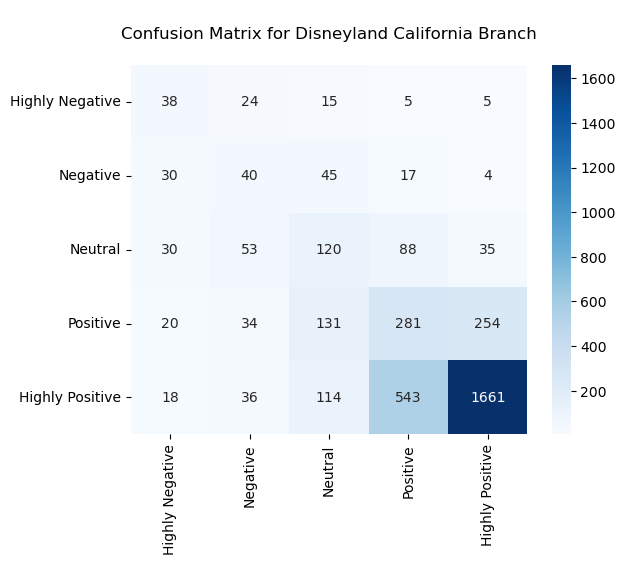

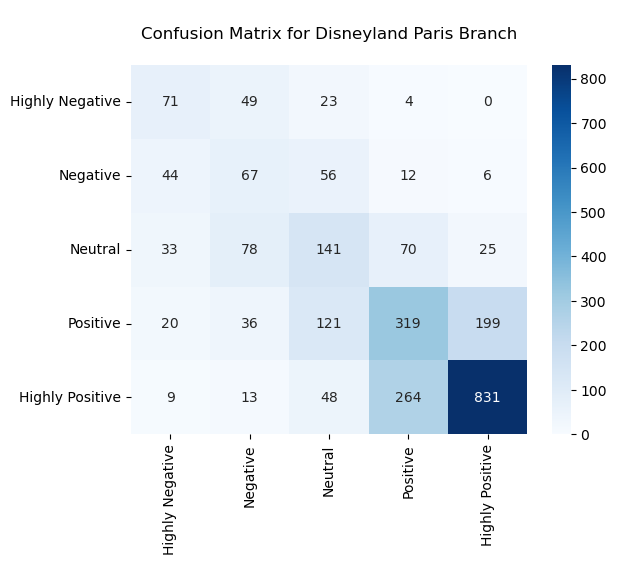

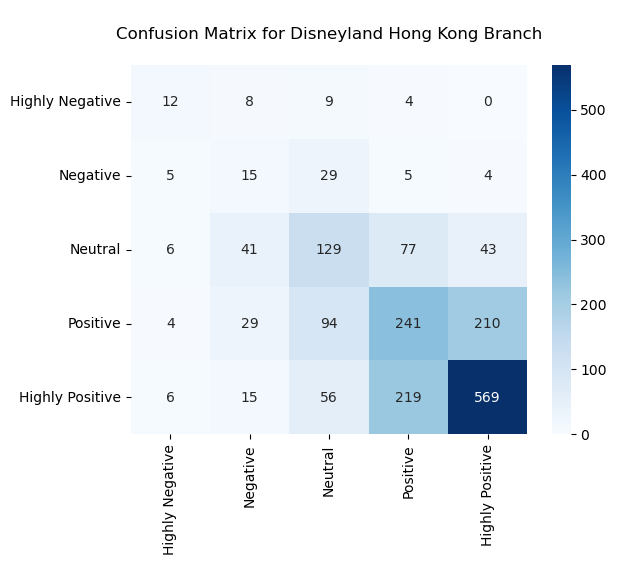

In [35]:
# The confusion matrices will be generated here using a function created for the outputting of a heatmap containing the 
# confusion matrix information.

def plot_confusion_matrix(Actual, Predictions, Disneyland_Branch, labels):
    cm = confusion_matrix(Actual, Predictions, labels = labels)
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = labels, yticklabels = labels)
    plt.title(f'\nConfusion Matrix for Disneyland {Disneyland_Branch} Branch\n')
    plt.show()

sentiment_labels = ['Highly Negative', 'Negative', 'Neutral', 'Positive', 'Highly Positive']

plot_confusion_matrix(cali_ytest, cali_logit_predictions, 'California', sentiment_labels)
plot_confusion_matrix(paris_ytest, paris_logit_predictions, 'Paris', sentiment_labels)
plot_confusion_matrix(hk_ytest, hk_logit_predictions, 'Hong Kong', sentiment_labels)

As seen by the results of the logistic models for each Disneyland branch, both the accuracy metric and the confusion matrix show improvement to the TextBlob model analysis. I'd like to once again point out the accuracy metrics of the TextBlob sentiment analyzer: 

Disneyland California: 18.92% accuracy
Disneyland Paris: 24.53% accuracy
Disneyland Hong Kong: 28.29% accuracy

With the logistic regression model's creation for each Disneyland branch with a balanced class weight factored in, the accuracy
has improved for each branch as shown below: 

Disneyland California: 58.78% accuracy
Disneyland Paris: 56.28% accuracy
Disneyland Hong Kong: 52.79% accuracy

While these improvements are significant along with the precision, recall, and F-1 score statistics showing similar increases, these models are simply not ready for deployment. So I will move along to the next model on the list: multinomial Naive Bayes.

In [36]:
# For the Naive Bayes model, I will create a function which will output the most optimal model based on grid search 
# parameters within a search space. This function will be applied to each Disneyland branch training set, once again taking
# class imbalance under consideration to output the performance metrics needed.

def naive_bayes_model(xtrain, ytrain, xtest, ytest, Disneyland_Branch):
    
    param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0], 'fit_prior': [True, False]}
                  
    nb_model = MultinomialNB()
    grid_search = GridSearchCV(estimator = nb_model, param_grid = param_grid, cv = 5, n_jobs = -1, scoring = 'accuracy')
    grid_search.fit(xtrain, ytrain)

    best_nb_model = grid_search.best_estimator_
    print(f'Best parameters for the Disneyland {Disneyland_Branch} model: {grid_search.best_params_}')

    nb_predictions = best_nb_model.predict(xtest)
    
    print(f'\nDisneyland {Disneyland_Branch} Naive Bayes Model Accuracy:', accuracy_score(ytest, nb_predictions))
    print(f'\nDisneyland {Disneyland_Branch} Naive Bayes Model Classification Report:\n', 
      classification_report(ytest, nb_predictions))
    
    return nb_predictions

cali_nb_predictions = naive_bayes_model(cali_xtrain_tfidf, cali_ytrain, cali_xtest_tfidf, cali_ytest, 'California')
paris_nb_predictions = naive_bayes_model(paris_xtrain_tfidf, paris_ytrain, paris_xtest_tfidf, paris_ytest, 'Paris')
hk_nb_predictions = naive_bayes_model(hk_xtrain_tfidf, hk_ytrain, hk_xtest_tfidf, hk_ytest, 'Hong Kong')

Best parameters for the Disneyland California model: {'alpha': 0.1, 'fit_prior': True}

Disneyland California Naive Bayes Model Accuracy: 0.6553144740455918

Disneyland California Naive Bayes Model Classification Report:
                  precision    recall  f1-score   support

Highly Negative       0.00      0.00      0.00        87
Highly Positive       0.67      0.99      0.80      2372
       Negative       0.00      0.00      0.00       136
        Neutral       0.33      0.02      0.03       326
       Positive       0.19      0.03      0.06       720

       accuracy                           0.66      3641
      macro avg       0.24      0.21      0.18      3641
   weighted avg       0.51      0.66      0.54      3641

Best parameters for the Disneyland Paris model: {'alpha': 0.1, 'fit_prior': False}

Disneyland Paris Naive Bayes Model Accuracy: 0.5395825128003151

Disneyland Paris Naive Bayes Model Classification Report:
                  precision    recall  f1-score   suppo

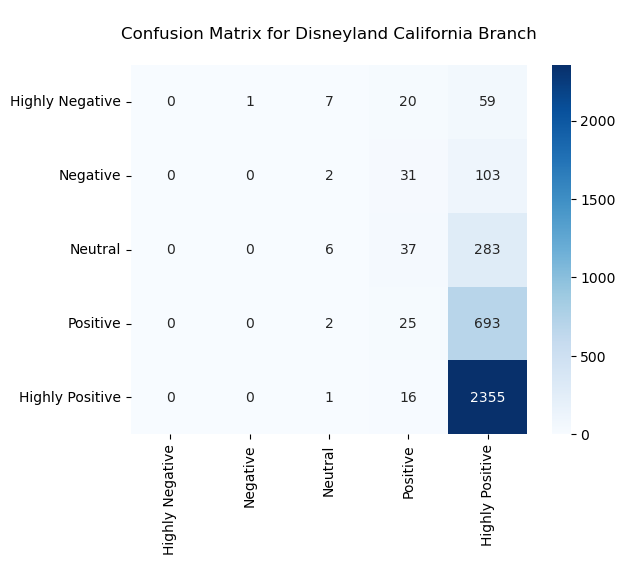

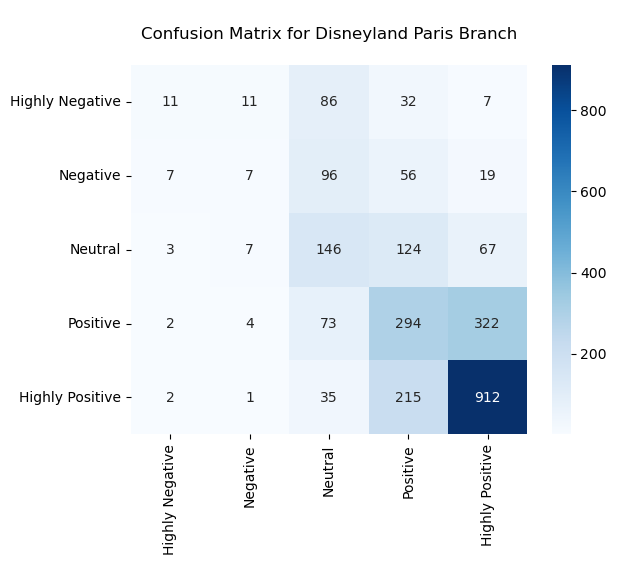

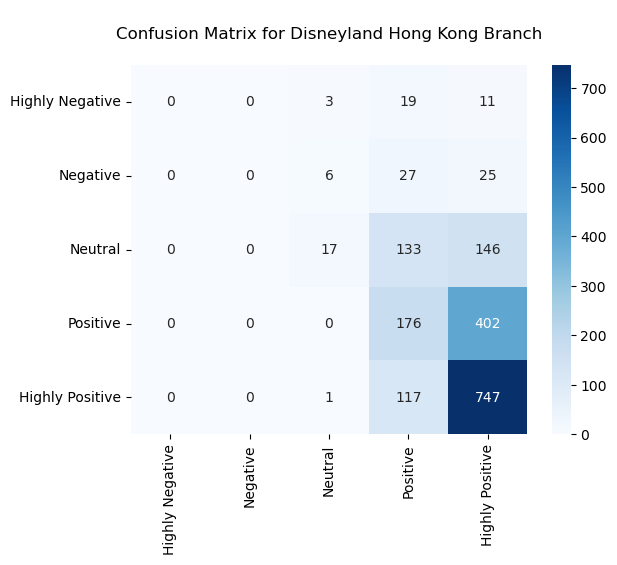

In [37]:
# The confusion matrix heatmap function will be used here again to output the confusion matrices for the three Disneyland 
# branches.

plot_confusion_matrix(cali_ytest, cali_nb_predictions, 'California', sentiment_labels)
plot_confusion_matrix(paris_ytest, paris_nb_predictions, 'Paris', sentiment_labels)
plot_confusion_matrix(hk_ytest, hk_nb_predictions, 'Hong Kong', sentiment_labels)

With the performance metrics from the Naive Bayes models, we can see the differences between the results from the logistic regression model. The accuracy metrics from the logistic regression model and the Naive Bayes model are shown below: 

Logistic Regression Model

Disneyland California: 58.78% accuracy
Disneyland Paris: 56.28% accuracy
Disneyland Hong Kong: 52.79% accuracy

Naive Bayes Model

Disneyland California: 65.53% accuracy
Disneyland Paris: 53.96% accuracy
Disneyland Hong Kong: 51.37% accuracy

It is interesting to note that Disneyland California's model accuracy increased, yet the other two branches had their model's accuracy decrease from logistic regression to Naive Bayes. It seems that the simplicity of these two models are not enough to 
handle the imbalanced number of highly positive and positive reviews, as the precision and recall metrics are rather high for these review classes, yet are very low for the other classes. The next model I wish to focus on is the random forest model, one that can handle many different regression and classification problems well.

In [38]:
# For the random forest model, I have made sure to use the RandomForestClassifier() function as this data lends itself to 
# classification as previously specified. I have encapsulated the model creation with preset parameters in a function to 
# output the performance metrics for each Disneyland branch's random forest classifier model. 

def random_forest_classifier(xtrain, ytrain, xtest, ytest, Disneyland_Branch):

    rf_classifier = RandomForestClassifier(n_estimators = 100, max_depth = None, min_samples_split = 2, 
                                           min_samples_leaf = 1, random_state = 123)

    rf_classifier.fit(xtrain, ytrain)

    rf_predictions = rf_classifier.predict(xtest)

    print(f'\nDisneyland {Disneyland_Branch} Random Forest Classifier Model Accuracy:', accuracy_score(ytest, 
                                                                                                       rf_predictions))
    print(f'\nDisneyland {Disneyland_Branch} Random Forest Classifier Model Classification Report:\n', 
          classification_report(ytest, rf_predictions))
    
    return rf_predictions

cali_rf_predictions = random_forest_classifier(cali_xtrain_tfidf, cali_ytrain, cali_xtest_tfidf, cali_ytest, 'California')
paris_rf_predictions = random_forest_classifier(paris_xtrain_tfidf, paris_ytrain, paris_xtest_tfidf, paris_ytest, 'Paris')
hk_rf_predictions = random_forest_classifier(hk_xtrain_tfidf, hk_ytrain, hk_xtest_tfidf, hk_ytest, 'Hong Kong')


Disneyland California Random Forest Classifier Model Accuracy: 0.653117275473771

Disneyland California Random Forest Classifier Model Classification Report:
                  precision    recall  f1-score   support

Highly Negative       0.00      0.00      0.00        87
Highly Positive       0.65      1.00      0.79      2372
       Negative       0.00      0.00      0.00       136
        Neutral       0.00      0.00      0.00       326
       Positive       0.40      0.01      0.02       720

       accuracy                           0.65      3641
      macro avg       0.21      0.20      0.16      3641
   weighted avg       0.51      0.65      0.52      3641


Disneyland Paris Random Forest Classifier Model Accuracy: 0.4954706577392674

Disneyland Paris Random Forest Classifier Model Classification Report:
                  precision    recall  f1-score   support

Highly Negative       1.00      0.01      0.03       147
Highly Positive       0.52      0.98      0.68      1165
 

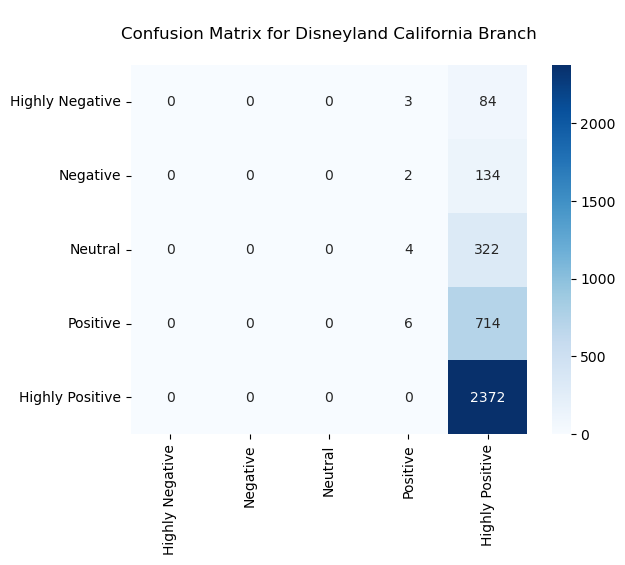

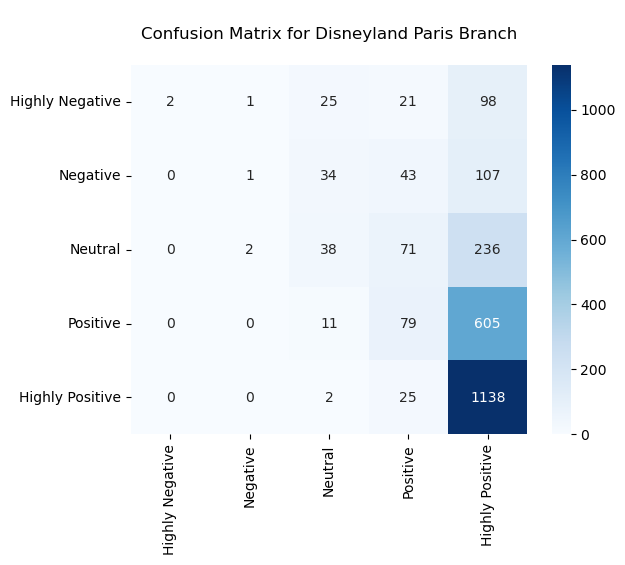

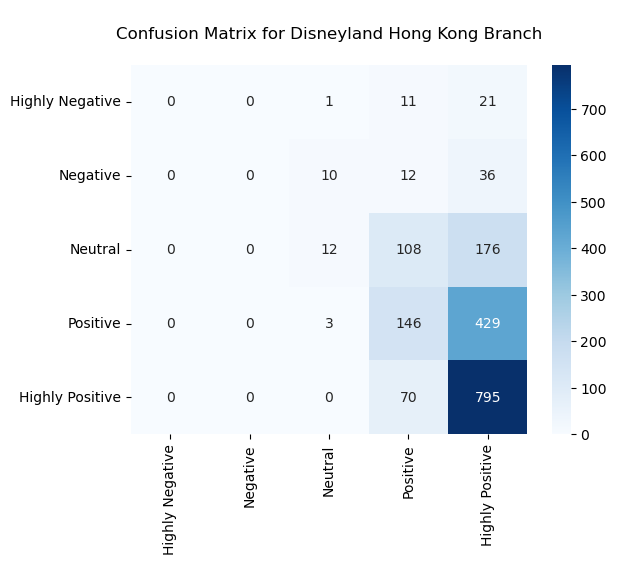

In [39]:
# The confusion matrix heatmap function will be used here again to output the confusion matrices for the three Disneyland 
# branches.

plot_confusion_matrix(cali_ytest, cali_rf_predictions, 'California', sentiment_labels)
plot_confusion_matrix(paris_ytest, paris_rf_predictions, 'Paris', sentiment_labels)
plot_confusion_matrix(hk_ytest, hk_rf_predictions, 'Hong Kong', sentiment_labels)

With the performance metrics from the random forest classifier models, we can see the differences between the results from the logistic regression models and Naive Bayes models. The accuracy metrics from the logistic regression models, the Naive Bayes models, and the random forest classifier models are shown below: 

Logistic Regression Model

Disneyland California: 58.78% accuracy
Disneyland Paris: 56.28% accuracy
Disneyland Hong Kong: 52.79% accuracy

Naive Bayes Model

Disneyland California: 65.53% accuracy
Disneyland Paris: 53.96% accuracy
Disneyland Hong Kong: 51.37% accuracy

Random Forest Classifier Model

Disneyland California: 65.31% accuracy
Disneyland Paris: 49.55% accuracy
Disneyland Hong Kong: 52.08% accuracy

Looking at the three models currently having their results displayed, the random forest classifier model does not seem to offer better performance as a whole than the Naive Bayes model. The only random forest classifier model that performed better than the previous one is the Disneyland Hong Kong model, but not by any significant percentage. Upon seeing the results of these first three predictive models, the Naive Bayes model still outputs the highest average accuracy, yet so far we have seen nothing worthy of deployment. Combined with the poor accuracy statistics, each of the precision, recall, and F-1 scores for every sentiment class other than Highly Positive are very low, with some of the classes receiving zeroes for their subsequent metrics. As it stands now, the only hope for attaining a potentially viable predictive model is the gradient boosting classifier model.

In [40]:
# To speed up the computation of the final models and include both Lasso and Ridge regularization, I am actually going to 
# use the extreme gradient boosting classifier algorithm. This gradient boosting algorithm boasts better performance on 
# larger datasets, allows for more parameters for tuning, and lets computation happen in a parallel nature. Since the class
# labels are string values yet the XGB classifier model takes integer class values, I am using LabelEncoder() to transform 
# the string classifications to integer values, which are then reverted back to the string labels at the prediction 
# generation code block. 

def xgb_classifier_model(xtrain, ytrain, xtest, ytest, Disneyland_Branch):

    le = LabelEncoder()
    ytrain_encoded = le.fit_transform(ytrain)
    ytest_encoded = le.transform(ytest)
    
    xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss', random_state = 123, n_estimators = 50, 
                              max_depth = 5, learning_rate = 0.1, n_jobs = -1)

    xgb_model.fit(xtrain, ytrain_encoded, eval_set = [(xtest, ytest_encoded)], verbose = False)

    xgb_predictions_encoded = xgb_model.predict(xtest)
    xgb_predictions = le.inverse_transform(xgb_predictions_encoded)
    
    print(f'Disneyland {Disneyland_Branch} XGBClassifier Model Accuracy:', accuracy_score(ytest, xgb_predictions))
    print(f'\nDisneyland {Disneyland_Branch} XGBClassifier Model Classification Report:\n', 
          classification_report(ytest, xgb_predictions))
    
    return xgb_predictions

cali_xgb_predictions = xgb_classifier_model(cali_xtrain_tfidf, cali_ytrain, cali_xtest_tfidf, cali_ytest, 'California')
paris_xgb_predictions = xgb_classifier_model(paris_xtrain_tfidf, paris_ytrain, paris_xtest_tfidf, paris_ytest, 'Paris')
hk_xgb_predictions = xgb_classifier_model(hk_xtrain_tfidf, hk_ytrain, hk_xtest_tfidf, hk_ytest, 'Hong Kong')

Disneyland California XGBClassifier Model Accuracy: 0.660258170832189

Disneyland California XGBClassifier Model Classification Report:
                  precision    recall  f1-score   support

Highly Negative       0.32      0.07      0.11        87
Highly Positive       0.68      0.99      0.81      2372
       Negative       0.21      0.02      0.04       136
        Neutral       0.31      0.03      0.06       326
       Positive       0.28      0.05      0.08       720

       accuracy                           0.66      3641
      macro avg       0.36      0.23      0.22      3641
   weighted avg       0.54      0.66      0.55      3641

Disneyland Paris XGBClassifier Model Accuracy: 0.5340685309176841

Disneyland Paris XGBClassifier Model Classification Report:
                  precision    recall  f1-score   support

Highly Negative       0.47      0.18      0.26       147
Highly Positive       0.58      0.92      0.71      1165
       Negative       0.38      0.06      0.10 

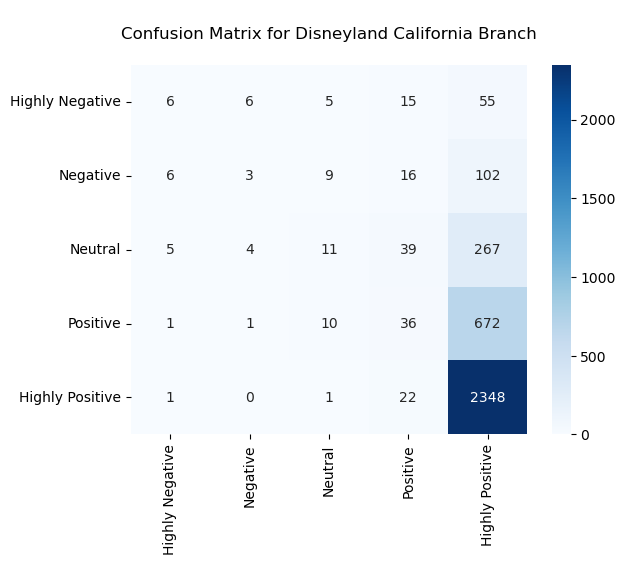

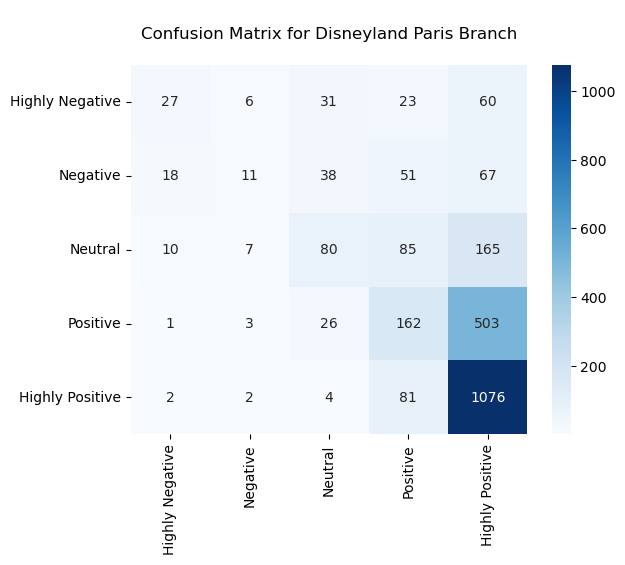

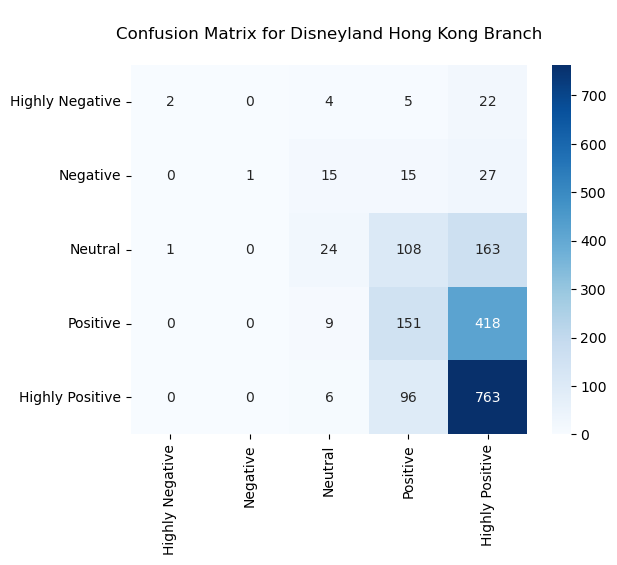

In [41]:
# The confusion matrix heatmap function will be used here again to output the confusion matrices for the three Disneyland 
# branches.

plot_confusion_matrix(cali_ytest, cali_xgb_predictions, 'California', sentiment_labels)
plot_confusion_matrix(paris_ytest, paris_xgb_predictions, 'Paris', sentiment_labels)
plot_confusion_matrix(hk_ytest, hk_xgb_predictions, 'Hong Kong', sentiment_labels)

With the performance metrics from the extreme gradient boosting models, we can see the differences between the results from the three previous models. The accuracy metrics from all four classifier models are shown below: 

Logistic Regression Model

Disneyland California: 58.78% accuracy
Disneyland Paris: 56.28% accuracy
Disneyland Hong Kong: 52.79% accuracy

Naive Bayes Model

Disneyland California: 65.53% accuracy
Disneyland Paris: 53.96% accuracy
Disneyland Hong Kong: 51.37% accuracy

Random Forest Classifier Model

Disneyland California: 65.31% accuracy
Disneyland Paris: 49.55% accuracy
Disneyland Hong Kong: 52.08% accuracy

Extreme Gradient Boosting Classifier Model

Disneyland California: 66.03% accuracy
Disneyland Paris: 53.41% accuracy
Disneyland Hong Kong: 51.42% accuracy

Now that all the models have been crafted, it is clear that none of these predictive models are accurate enough to be considered for deployment. Each classification report printed has been lackluster in accurately predicting imbalanced class review sentiment. There are many ways to address this in the future to increase accuracy, however without more computational power and memory, it may take too long to process. Such techniques to potentially increase accuracy, precision, recall, and F-1 scores are as seen below: 

1. Run the previous predictive models using TextBlob's new review text sentiment values
2. Enforce more hyperparameter tuning techniques specific to the class imbalance
3. Incorporate class balancing methods by either duplicating the minority class values to equal the number of majority data points or dropping enough majority values to equal the number of the minority class values

As it stands, the Naive Bayes model and the extreme gradient boosting classifier model accuracy metrics are the best of the four models. Out of these two, the extreme gradient boosting model exhibits the better-performing classification report, so we can declare this predictive model the best of the bunch.